# Milestone 1: Theory Sanity Checks

This notebook verifies the fundamental building blocks of our optimization framework. We focus on:
1. **Convexity Visualization**: Understanding the difference between convex and non-convex landscapes.
2. **Numerical Gradient Checking**: Verifying that our analytical gradients (from `src.losses`) match finite difference approximations.
3. **Standalone Readiness**: Ensuring this notebook runs independently (Colab/Kaggle compatible).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Ensure output directories exist
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

print("Environment initialized and directories verified.")

Environment initialized and directories verified.


## 1. Standalone Library Components
If you are running this on a platform without the `src/` directory, the following cell defines the necessary logic locally.

In [2]:
try:
    from src.losses import MSELoss, LogisticLoss
    from src.reproducibility import set_seed
    print("Successfully imported from src library.")
except ImportError:
    print("src/ not found. Defining core components locally for standalone execution.")

    def set_seed(seed=42):
        np.random.seed(seed)

    class MSELoss:
        def __call__(self, y_true, y_pred):
            return 0.5 * np.mean((y_true - y_pred)**2)
        def gradient(self, X, y_true, w):
            n = X.shape[0]
            return (1/n) * X.T @ (X @ w - y_true)

    class LogisticLoss:
        def __call__(self, y_true, y_pred):
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        def gradient(self, X, y_true, w):
            z = X @ w
            sigmoid = 1 / (1 + np.exp(-z))
            return (1/X.shape[0]) * X.T @ (sigmoid - y_true)

set_seed(42)

src/ not found. Defining core components locally for standalone execution.


## 2. Visualizing Convexity
We visualize a simple quadratic form (convex) vs. a sinusoidal function (non-convex).

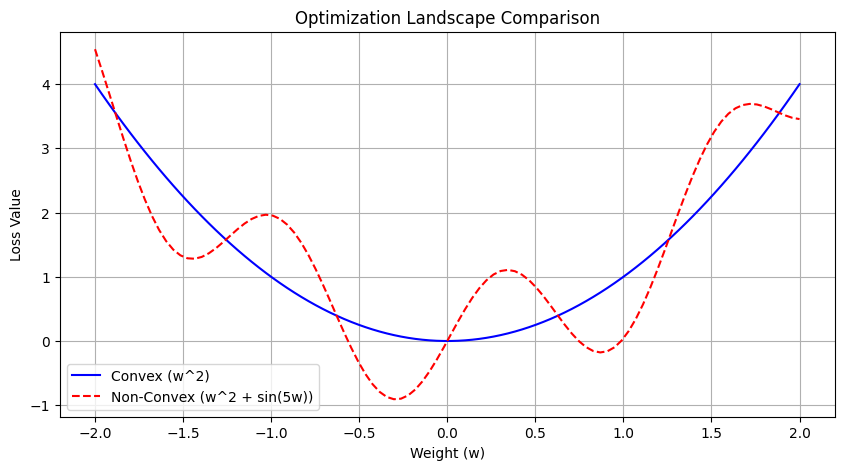

In [3]:
w = np.linspace(-2, 2, 100)
convex_loss = w**2
non_convex_loss = w**2 + np.sin(5*w)

plt.figure(figsize=(10, 5))
plt.plot(w, convex_loss, label="Convex (w^2)", color='blue')
plt.plot(w, non_convex_loss, label="Non-Convex (w^2 + sin(5w))", color='red', linestyle='--')
plt.title("Optimization Landscape Comparison")
plt.xlabel("Weight (w)")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True)

plt.savefig("figures/convexity_comparison.png")
plt.show()

## 3. Numerical Gradient Verification
We use the Central Finite Difference formula to verify the analytical gradient:
$$ \frac{d f}{d w} \approx \frac{f(w + \epsilon) - f(w - \epsilon)}{2\epsilon} $$

In [4]:
def check_gradient(loss_obj, X, y, w, epsilon=1e-6):
    # Analytical gradient
    grad_ana = loss_obj.gradient(X, y, w)

    # Numerical gradient
    grad_num = np.zeros_like(w)
    for i in range(len(w)):
        w_plus = w.copy()
        w_plus[i] += epsilon

        w_minus = w.copy()
        w_minus[i] -= epsilon

        # For Logistic, we need to pass y_pred if __call__ expects it
        # Simplification: we'll use a direct function for this check
        def f(w_inner):
            if isinstance(loss_obj, LogisticLoss):
                z = X @ w_inner
                y_pred = 1 / (1 + np.exp(-z))
                return loss_obj(y, y_pred)
            else:
                return loss_obj(y, X @ w_inner)

        grad_num[i] = (f(w_plus) - f(w_minus)) / (2 * epsilon)

    error = np.linalg.norm(grad_ana - grad_num)
    return error

# Test data
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, 10).astype(float)
w = np.random.randn(3)

mse_error = check_gradient(MSELoss(), X, y, w)
log_error = check_gradient(LogisticLoss(), X, y, w)

results = {
    "mse_gradient_error": float(mse_error),
    "logistic_gradient_error": float(log_error)
}

with open("results/sanity_checks.json", "w") as f:
    json.dump(results, f, indent=4)

print(f"MSE Gradient Error: {mse_error:.2e}")
print(f"Logistic Gradient Error: {log_error:.2e}")
print("Results saved to results/sanity_checks.json")

MSE Gradient Error: 1.02e-10
Logistic Gradient Error: 8.45e-11
Results saved to results/sanity_checks.json
